## Setup
As usual, we first import Mitsuba and Dr.Jit and set a variant that supports automatic differentiation.

In [2]:
%load_ext autoreload
%autoreload 2

import drjit as dr
import mitsuba as mi
mi.set_variant('cuda_ad_rgb', 'llvm_ad_rgb')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import matplotlib.pyplot as plt
import config as cf
import integrators
import training
import visualization
import example_usage


In [3]:
# Example 1: Using the modular structure for a quick experiment
print("=== Example 1: Quick Experiment with Modular Structure ===")

# Create a configuration for a quick test
config = cf.create_config("tlir_notebook_test", 
                           num_stages=4,
                           num_iterations_per_stage=15,
                           grid_init_res=16)
config.num_stages = 4
config.num_iterations_per_stage = 50
config.render_res = 256
config.sensor_count = 8
config.spp = 1
config.loss_type = 'l2'

# Validate the configuration
issues = cf.validate_config(config)
if issues:
    print("Configuration issues:", issues)
else:
    print("Configuration is valid!")

print(f"Experiment: {config.experiment_name}")
print(f"Output directory: {config.output_dir}")
print(f"Stages: {config.num_stages}, Iterations per stage: {config.num_iterations_per_stage}")
print(f"Grid resolution: {config.grid_init_res}")
print(f"Integrator: {config.integrator_type}")


=== Example 1: Quick Experiment with Modular Structure ===
Configuration is valid!
Experiment: tlir_notebook_test
Output directory: ./outputs/tlir_notebook_test_20251002_110802
Stages: 4, Iterations per stage: 50
Grid resolution: 16
Integrator: rf_prb


=== Example 2: Creating Sensors and Scene ===
Created 8 sensors with resolution 256
Created scene with integrator: rf_prb
Rendered 8 reference images


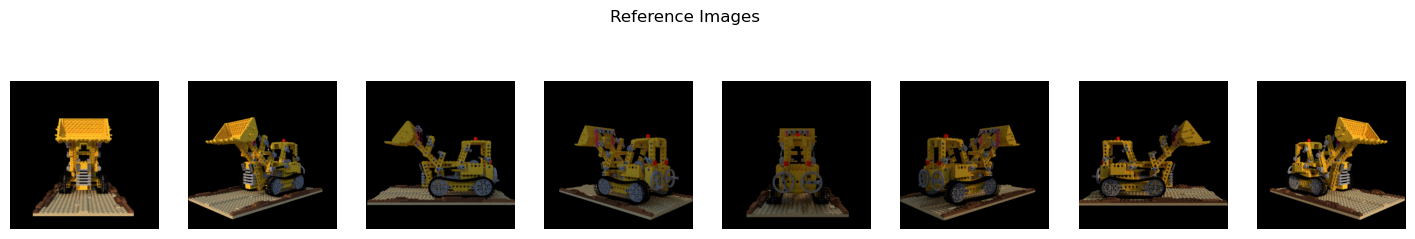

In [4]:
# Example 2: Create sensors and scene using modular functions
print("=== Example 2: Creating Sensors and Scene ===")

# Create sensors using the modular function
sensors = training.create_sensors(
    num_sensors=config.sensor_count,
    render_res=config.render_res,
    center=config.camera_center,
    radius=config.camera_radius
)

print(f"Created {len(sensors)} sensors with resolution {config.render_res}")

# Create scene using the modular function
scene = training.create_scene(config.integrator_type)
print(f"Created scene with integrator: {config.integrator_type}")

# Load reference scene and render reference images
scene_ref = mi.load_file(config.scene_file)
ref_images = [mi.render(scene_ref, sensor=sensors[i], spp=128) for i in range(config.sensor_count)]

print(f"Rendered {len(ref_images)} reference images")

visualization.plot_list(ref_images, 'Reference Images')


In [5]:
# Example 3: Run training using the modular training function
print("=== Example 3: Training with Modular Structure ===")

# Set up logger
logger = visualization.TrainingLogger()

# Run training using the modular function
holdout_every = 4
sensors_heldout = sensors[1:-1:holdout_every]
ref_images_heldout = ref_images[1:-1:holdout_every]

sensors_train = [s for i, s in enumerate(sensors) if (i + 1) % holdout_every != 0 or i == len(sensors) - 1]
ref_images_train = [ref_images[i] for i in range(len(ref_images)) if (i + 1) % holdout_every != 0 or i == len(ref_images) - 1]

results = training.train_radiance_field(
    scene=scene,
    sensors=sensors_train,
    ref_images=ref_images_train,
    config=config,
    progress_callback=logger.log_progress
)

print(f"Training completed!")
print(f"Total iterations: {len(results['losses'])}")
print(f"Initial loss: {results['losses'][0]:.6f}")
print(f"Final loss: {results['losses'][-1]:.6f}")
print(f"Improvement: {results['losses'][0] - results['losses'][-1]:.6f}")


=== Example 3: Training with Modular Structure ===
Stage 01, feature voxel grids resolution -> 16
[11:08:10] Stage 01, Iteration 01: Loss = 1.34541
[11:08:10] Stage 01, Iteration 02: Loss = 1.3386
[11:08:10] Stage 01, Iteration 03: Loss = 1.32618
[11:08:10] Stage 01, Iteration 04: Loss = 1.32085
[11:08:10] Stage 01, Iteration 05: Loss = 1.31706
[11:08:10] Stage 01, Iteration 06: Loss = 1.31459
[11:08:10] Stage 01, Iteration 07: Loss = 1.31336
[11:08:10] Stage 01, Iteration 08: Loss = 1.31254
[11:08:10] Stage 01, Iteration 09: Loss = 1.3117
[11:08:10] Stage 01, Iteration 10: Loss = 1.31091
[11:08:10] Stage 01, Iteration 11: Loss = 1.31038
[11:08:10] Stage 01, Iteration 12: Loss = 1.31005
[11:08:10] Stage 01, Iteration 13: Loss = 1.30971
[11:08:10] Stage 01, Iteration 14: Loss = 1.30931
[11:08:10] Stage 01, Iteration 15: Loss = 1.30898
[11:08:10] Stage 01, Iteration 16: Loss = 1.30874
[11:08:10] Stage 01, Iteration 17: Loss = 1.30853
[11:08:11] Stage 01, Iteration 18: Loss = 1.30831
[11:

=== Example 4: Visualization with Modular Structure ===


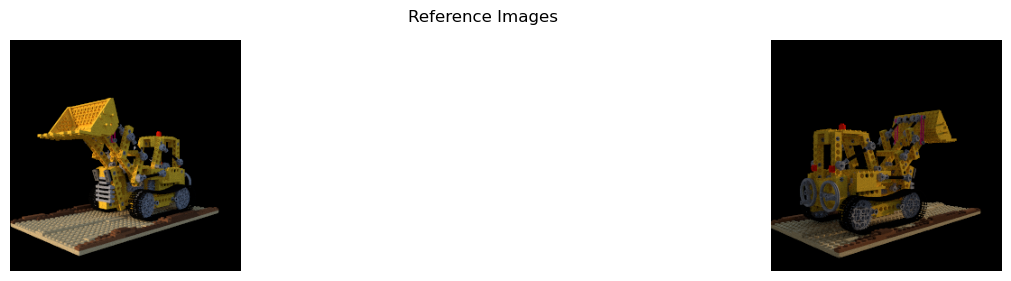

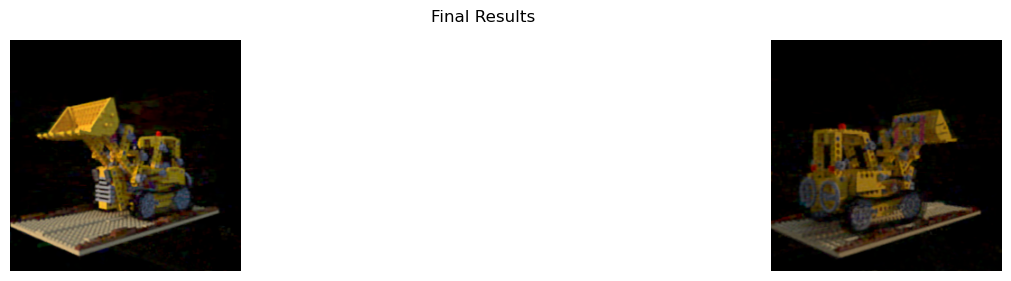

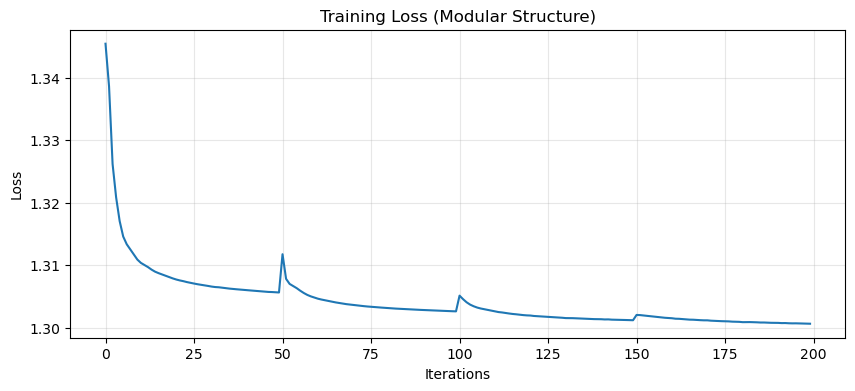

In [6]:
# Example 4: Visualize results using modular visualization functions
print("=== Example 4: Visualization with Modular Structure ===")

# Render final results
final_images = [mi.render(scene, sensor=sensors_heldout[i], spp=128) for i in range(len(sensors_heldout))]

# Use modular plotting functions
visualization.plot_list(ref_images_heldout, 'Reference Images')
visualization.plot_list(final_images, 'Final Results')

# Plot loss curve
plt.figure(figsize=(10, 4))
plt.plot(results['losses'])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss (Modular Structure)')
plt.grid(True, alpha=0.3)
plt.show()


=== Example 6: Ratio Tracking with Modular Structure ===
Ratio tracking config: notebook_rt_test
Initial majorant: 10.0
Stop gradient on density: False
Stage 01, feature voxel grids resolution -> 16
Stage 02, feature voxel grids resolution -> 32
Stage 03, feature voxel grids resolution -> 64
Stage 04, feature voxel grids resolution -> 128
  --> iteration 50: error=1.30082
Done
Ratio tracking training completed!
Final loss: 1.300824


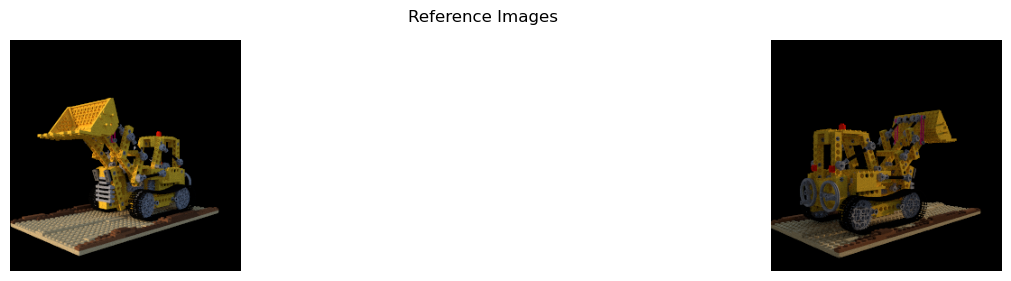

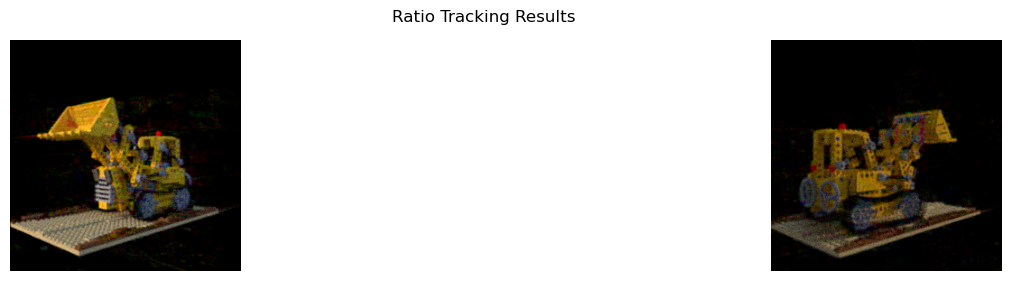

In [8]:
# Example 6: Using ratio tracking integrator with modular structure
print("=== Example 6: Ratio Tracking with Modular Structure ===")

# Create configuration for ratio tracking
config_rt = cf.create_ratio_tracking_config("notebook_rt_test")
config_rt.num_stages = 4
config_rt.num_iterations_per_stage = 50
config_rt.render_res = 256
config_rt.sensor_count = 8
config_rt.spp = 64
config_rt.loss_type = 'l2'

print(f"Ratio tracking config: {config_rt.experiment_name}")
print(f"Initial majorant: {config_rt.initial_majorant}")
print(f"Stop gradient on density: {config_rt.stopgrad_density}")

# Create scene with ratio tracking integrator
scene_rt_modular = training.create_scene('rf_prb_rt')
sensors_rt = training.create_sensors(
    num_sensors=config_rt.sensor_count,
    render_res=config_rt.render_res
)

# Train with ratio tracking
results_rt_modular = training.train_radiance_field(
    scene=scene_rt_modular,
    sensors=sensors_train,
    ref_images=ref_images_train,
    config=config_rt
)

print(f"Ratio tracking training completed!")
print(f"Final loss: {results_rt_modular['losses'][-1]:.6f}")

# Render and display results
final_images_rt_modular = [mi.render(scene_rt_modular, sensor=sensors_heldout[i], spp=256) for i in range(len(sensors_heldout))]
visualization.plot_list(ref_images_heldout, 'Reference Images')
visualization.plot_list(final_images_rt_modular, 'Ratio Tracking Results')
